In [1]:
import autoencodeSVJ.evaluate as ev
import autoencodeSVJ.utils as utils
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import numpy as np

Using TensorFlow backend.


In [2]:
space = [
    Integer(2, 30, name='target_dim'),
#     Integer(0, 1, name='hlf'),
    Real(1e-4, 1e-1, name='learning_rate', prior='log-uniform'), 
    Integer(3, 4, name='eflow_base')
]

In [3]:
filtered = utils.summary().cfilter([elt.name for elt in space] + ["*auc"])

keep = filtered.copy()
for elt in space:
    if isinstance(elt, Categorical):
        keep = keep[keep[elt.name].isin(elt.categories)]
    else:
        keep = keep[keep[elt.name].between(*elt.bounds)]
        if isinstance(elt, Integer):
            keep = keep[keep[elt.name].apply(lambda x: float(x).is_integer())]

aucs = keep.loc[:,~keep.columns.isin([elt.name for elt in space])]

x0 = np.asarray([keep[item.name].values for item in space]).T.tolist()
y0 = map(lambda x: 1 - x,aucs.max(axis=1).tolist())
# x0 = [list(keep [item.name].values) for item in space]
# y0 = auc.max(axis=1).tolist()

In [ ]:
random_state = 42

@use_named_args(space)
def objective(**X):
    print "computing configuration {}".format(X)
    
    # minimize 1 - auc
    auc = 1. - ev.ae_train(
        qcd_path='data/background/base_{}/*.h5'.format(X['eflow_base']),
        signal_path="data/signal/base_{}/*.h5".format(X['eflow_base']),
        epochs=100,
        hlf=0,
        target_dim=X['target_dim'],
#         val_split=X['val_split'],
        learning_rate=X['learning_rate'],
        optimizer='adam',
#         loss=X['loss'],
        seed=random_state,
        verbose=0,
    )
    
    print "Max AUC:", 1 - auc
    return auc

results = gp_minimize(
    objective, space, verbose=1, 
    n_calls=100, 
    n_random_starts=20, 
    random_state=random_state
)

Iteration No: 1 started. Evaluating function at random point.
computing configuration {'eflow_base': 4, 'learning_rate': 0.00035506214270707701, 'target_dim': 24}
Max AUC: 0.987969608911
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 95.1776
Function value obtained: 0.0120
Current minimum: 0.0120
Iteration No: 2 started. Evaluating function at random point.
computing configuration {'eflow_base': 3, 'learning_rate': 0.0021751953118777658, 'target_dim': 19}


In [ ]:
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

plot_convergence(results)
plt.show()

In [ ]:
print "Best parameters:"
for i,elt in enumerate(space):
    print "{} = {}".format(elt.name, results.x[i])

In [22]:
def pretty_plot(**fdict):

    cols = set().union(*[list(frame.columns) for frame in fdict.values()])
    parts = set().union(*[list(frame.index) for frame in fdict.values()])

    for name in fdict:
        fdict[name].fillna(0, inplace=True)

        for v in cols:
            if v not in fdict[name]:
                fdict[name][v] = 0
        for i in parts:
            if i not in fdict[name].index:
                fdict[name].loc[i] = 0

        fdict[name] = fdict[name][sorted(fdict[name].columns)]
        fdict[name].sort_index(inplace=True)

    for i,name in enumerate(fdict):
        ax = fdict[name].plot.bar(stacked=True, title=name, figsize=(8,8))
        ax.set_xlabel("PID")
        ax.set_ylabel("Count")

        legend = ax.get_legend()
        legend.set_title("Status")
    #     plt.suptitle(name)
        plt.show()
        
    return fdict


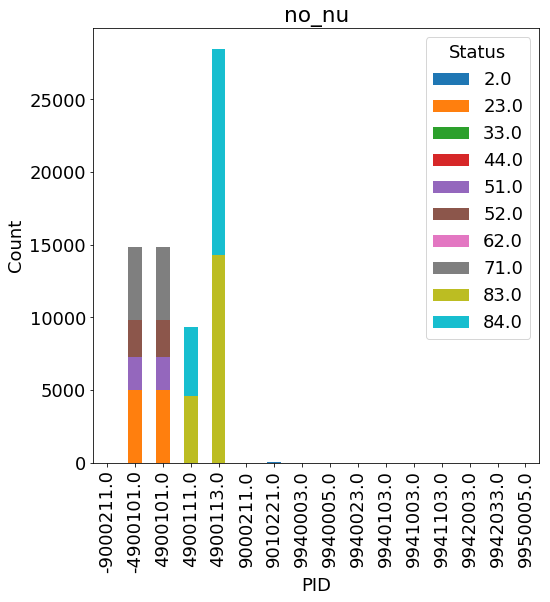

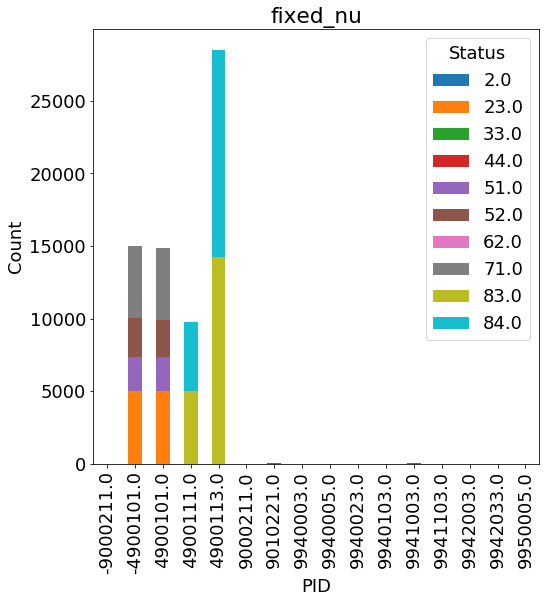

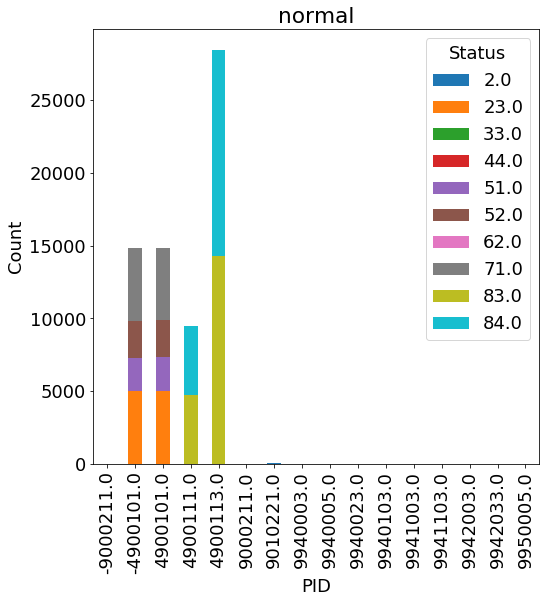

In [55]:
import matplotlib.pyplot as plt
fdict = pretty_plot(normal=normal.copy(), fixed_nu=fixed_nu.copy(), no_nu=no_nu.copy())